### This notebook describes the steps to perform elevation-based analysis of long-term changes in snow cover by accessing open-source datasets using STAC API.

#### Import necessary libraries

In [8]:
import odc.stac
import planetary_computer
import pystac_client
import stackstac
import rich.table
import xarray as xr
import pystac
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from xrspatial.zonal import stats
from rasterio.enums import Resampling
from dask.diagnostics import ProgressBar
import dask.array as da
import rasterio
import rioxarray

#### Check versions 

In [9]:
print(rasterio.__version__)
print(stackstac.__version__)
print(odc.stac.__version__)

1.3.7
0.4.3
0.3.6


#### Change working directory to github repo folder

In [10]:
import os
os.chdir('/home/jovyan/PlanetaryComputerExamples/assignments/geog313_project')

#### Hard-code variables for this specific analysis

In [11]:
# bounding box in lat/long for ladakh region 
bounding_box = [72, 32, 81, 38]
geojson_file_path = 'data/india_states.geojson'

# MODIS Daily Snow Product collection
modis_collection = ['modis-10A1-061']
snow_band = ['NDSI_Snow_Cover']

# NASA DEM collection
nasa_dem_collection = ['nasadem']
elevation_bands = ['elevation']

#### Create date list in pandas datetime format for the time period (Summer months)

In [12]:
def create_date_list(start_year,end_year):
    date_list = []
    for year in range(start_year, end_year + 1):
        start_date = pd.to_datetime(f'{year}-05-01', utc=True)
        end_date = pd.to_datetime(f'{year}-08-31', utc=True)
        date_list.append((start_date, end_date))
    return date_list

date_list = create_date_list(2010,2022)

#### Read GeoJson, Select study area, and Reproject to PCS

In [13]:
def create_study_area(geojson_path, state_column, state_name, target_epsg_code):
    boundaries = gpd.read_file(geojson_path)
    ladakh = boundaries.loc[boundaries[state_column] == state_name]
    ladakh_projected = ladakh.to_crs(epsg=target_epsg_code)
    return ladakh_projected.geometry

Text(0.5, 1.0, 'Ladakh')

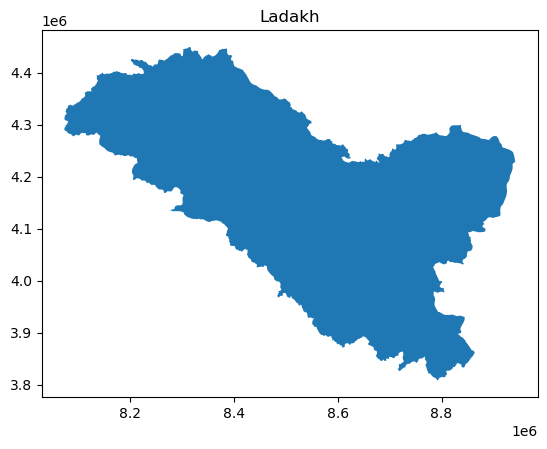

In [14]:
ladakh_geometry = create_study_area(geojson_file_path,'ST_NM', 'Ladakh' , 3857)
#lad_geometry = ladakh_projected.__geo_interface__['features'][0]['geometry']
ladakh_geometry.plot()
plt.title('Ladakh')

#### Initiate Local Dask Cluster

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

#### Connect to STAC API endpoint


In [16]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

#### Obtain data as XArray Dataset by searching the STAC collection ( MODIS Snow Cover)

In [21]:
def create_xarray_dataset(catalog, collection, datetime, bands, crs, resolution):
    search = catalog.search(
        collections=collection,
        bbox=bounding_box,
        #intersects=lad_geometry,
        datetime=datetime
    )
    items = search.item_collection() 
    data = odc.stac.load(
            items,
            bands=bands,
            crs=crs,
            bbox =bounding_box,
            #geopolygon = lad_geometry,
            resolution=resolution,
            chunks={'x':2048,'y':2048},
    )
    return data

In [22]:
modis_data = create_xarray_dataset(catalog, modis_collection, date_list[12], snow_band, 'EPSG:3857', 500)

In [23]:
modis_data

<xarray.Dataset>
Dimensions:          (y: 1633, x: 2004, time: 123)
Coordinates:
  * y                (y) float64 4.579e+06 4.579e+06 ... 3.764e+06 3.763e+06
  * x                (x) float64 8.015e+06 8.016e+06 ... 9.016e+06 9.017e+06
    spatial_ref      int32 3857
  * time             (time) datetime64[ns] 2022-05-01 2022-05-02 ... 2022-08-31
Data variables:
    NDSI_Snow_Cover  (time, y, x) uint8 dask.array<chunksize=(1, 1633, 2004), meta=np.ndarray>

#### Clip XArray to study area

In [24]:
def clip_xarray(geometry):
    modis_sc = modis_data['NDSI_Snow_Cover']
    sc_clipped = modis_sc.rio.clip(geometry, drop=True)
    return sc_clipped

#### Group data and Create a Binary Snow Cover dataset

In [25]:
def process_data(data_array):
    
    # clean data by filling with na values
    #values from 200-255 are codes for bad pixels
    data_array = data_array.where(data_array <= 100) 
    # group data (daily) into monthly data along the time dimension using mean
    monthly_mean_sc = data_array.groupby('time.month').mean(dim='time')
    # create binary map for snow using 50% as threshold
    binary_sc = xr.where(monthly_mean_sc >= 50, 1, 0)
    
    return binary_sc

In [26]:
sc_clipped = clip_xarray(ladakh_geometry)
binary_sc = process_data(sc_clipped)
binary_sc

<xarray.DataArray 'NDSI_Snow_Cover' (month: 4, y: 1284, x: 1736)>
dask.array<where, shape=(4, 1284, 1736), dtype=int64, chunksize=(1, 1284, 1736), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.45e+06 4.449e+06 ... 3.809e+06 3.808e+06
  * x            (x) float64 8.074e+06 8.075e+06 ... 8.941e+06 8.942e+06
    spatial_ref  int64 0
  * month        (month) int64 5 6 7 8

In [27]:
binary_sc[0].rio.crs

CRS.from_epsg(3857)

In [28]:
binary_sc[0].rio.bounds()

(8074000.0, 3808000.0, 8942000.0, 4450000.0)

#### Obtain data as XArray Dataset by searching the STAC collection ( NASADEM )

In [17]:
def get_elevation_data(catalog, collection, bands, epsg, resolution):
    search = catalog.search(
        collections=collection, 
        bbox = bounding_box
    )
    items = search.item_collection()
    data = stackstac.stack(
        items,
        bands,
        bounds_latlon = bounding_box,
        epsg=epsg,
        resolution = resolution
    )
    return data

#### *UserWarning expected as time dimension does not represent time points, it represents number of different tiles within the study area, each having different bounds*

In [18]:
nasadem = get_elevation_data(catalog, nasa_dem_collection, elevation_bands, 3857, 500)
nasadem

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-b8caf78e603be4df8ed12a0f64e2dafd' (time: 88,
                                                                band: 1,
                                                                y: 1633, x: 2004)>
dask.array<fetch_raster_window, shape=(88, 1, 1633, 2004), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2000-02-20 2000-02-20 ... 2000-02-20
    id          (time) <U19 'NASADEM_HGT_n38e081' ... 'NASADEM_HGT_n31e071'
  * band        (band) <U9 'elevation'
  * x           (x) float64 8.015e+06 8.016e+06 ... 9.016e+06 9.016e+06
  * y           (y) float64 4.58e+06 4.579e+06 4.578e+06 ... 3.764e+06 3.764e+06
    proj:shape  object {3601}
    proj:epsg   int64 4326
    title       <U9 'Elevation'
    epsg        int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(8015000, 3763000, 9017000, 457...
    crs:         epsg:3857
    transform:   | 500.00, 0.00, 8015000.00|\n| 0.00,-500.00, 4579500.00|\n| ...
    resolution:  500

#### Mosaic Elevation data to combine multiple tiles together

In [29]:
nasadem_mosaicked = stackstac.mosaic(nasadem, dim ='time')
# clip elevation data to study area
dem_clipped = nasadem_mosaicked.rio.clip(ladakh_geometry, drop=True)
# match data bounds, projection to snow data to perform zonal statistics
dem_clipped = dem_clipped.rio.reproject_match(binary_sc[0], resampling = Resampling.bilinear)

In [30]:
print(nasadem.shape)
print(dem_clipped.shape)

(88, 1, 1633, 2004)
(1, 1284, 1736)


#### Clean the elevation data to remove Inf and Nan values

In [31]:
def clean_elevation_data(data_array):
    data_array = xr.where(np.isinf(data_array), 0, data_array)
    data_array = data_array.fillna(0)
    data_array = data_array.where(data_array <= 9000, 0)
    return data_array

#### Get Minimum and Maximum elevation values in the study region

In [32]:
dem_data = clean_elevation_data(dem_clipped)
print(np.min(dem_data.data))
print(np.max(dem_data.data))

0.0
8216.0


#### Divide study area into 5 classes based on elevation ranges

In [33]:
def classify_dem(dem):
# Define the bins for elevation ranges
    class_bins = (0, 3000, 4000, 5000, 6000, 9000)
    dem_classified = xr.apply_ufunc(
        np.digitize,
        dem[0],
        class_bins,
        dask='parallelized',
        keep_attrs=True
    )
    return dem_classified

#### Plot the Classified DEM

Text(0.5, 1.0, 'Classified Map of Elevation')

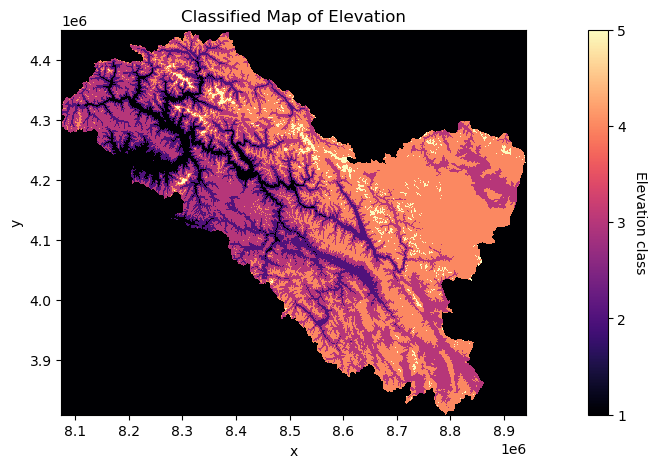

In [34]:
dem_classified = classify_dem(dem_data)

fig, ax = plt.subplots(figsize=(8, 5))
specific_ticks = [1,2,3,4,5]
img  = dem_classified.plot.imshow(cmap = 'magma', add_colorbar=False)
# Customize the colorbar
cbar = plt.colorbar(img,ax=ax, label='Elevation class',ticks=specific_ticks, orientation='vertical', pad=0.1)
cbar.set_label('Elevation class', rotation=270, labelpad=15)

plt.title('Classified Map of Elevation')

#### Change data from ndarray to dask array, and data type to float to be compatible for zonal statistics



In [35]:
dem_classified = dem_classified.chunk({'x': 100, 'y': 100})
dem_classified = dem_classified.astype('float64')

#### Run zonal stats for each month in summer (May,June,July,August) for elevation classes 2, 3, and 4.

In [173]:
def run_zonal_stats(zones, sc_array, func):
    zonal_stats_list = []
    for month_index in range(len(sc_array['month'])):
        # Select a single month
        binary_sc_month = sc_array.isel(month=month_index)
        sc_stats = stats(
            zones=zones,
            values=binary_sc_month,
            zone_ids=[2.0,3.0,4.0],
            stats_funcs=func
        ).compute()
        # Store zonal statistics in the dictionary using the time as the key
        sc_stats['month'] = sc_array['month'].values[month_index]
        zonal_stats_list.append(sc_stats)
    # Concatenate the individual DataFrames into a single Pandas DataFrame
    zonal_stats_df = pd.concat(zonal_stats_list, ignore_index=True)
    return zonal_stats_df

In [174]:
zonal_stats = run_zonal_stats(dem_classified, binary_sc, ['sum'])

In [176]:
zonal_stats['year'] = 2022

In [177]:
zonal_stats

,zone,sum,month,year
0,2.0,460.0,5,2022
1,3.0,29404.0,5,2022
2,4.0,10451.0,5,2022
3,2.0,82.0,6,2022
4,3.0,13013.0,6,2022
5,4.0,9944.0,6,2022
6,2.0,42.0,7,2022
7,3.0,2909.0,7,2022
8,4.0,6474.0,7,2022
9,2.0,34.0,8,2022


In [180]:
# final_zonal_stats_df = pd.DataFrame(columns=zonal_stats_df.columns)
#final_zonal_stats_df = pd.concat([final_zonal_stats_df, zonal_stats_df] , ignore_index=True)
result_csv_file = 'data/sc_zonal_stats.csv'
sc_zonal_stats = pd.read_csv(result_csv_file)

#### Plot the zonal stats using bar plots


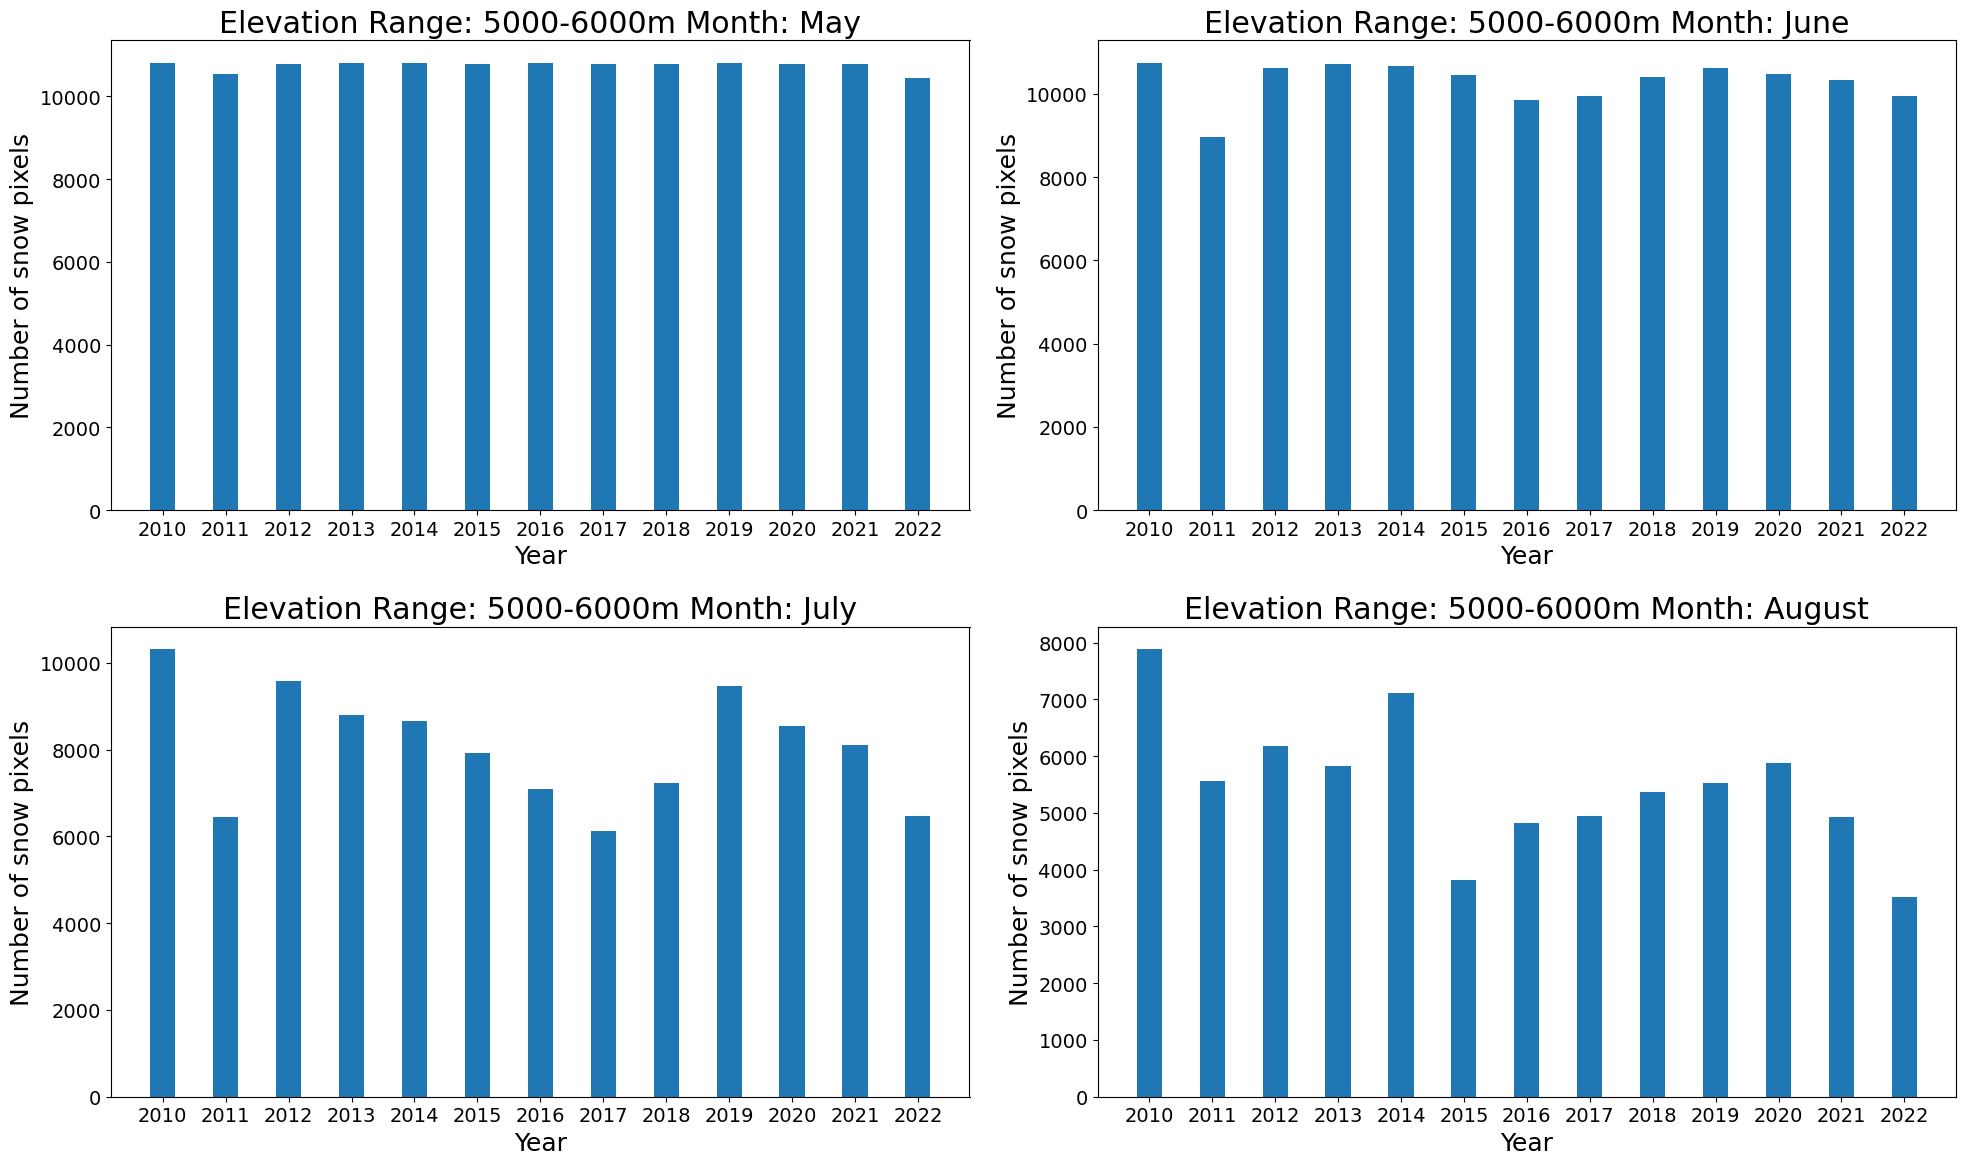

In [221]:
# Dictionary with zones and corresponding elevation ranges
zone_ranges = {2.0: '3000-4000m', 3.0: '4000-5000m', 4.0: '5000-6000m'}
# Dictionary with months and corresponding values
month_values = {5: 'May', 6: 'June', 7: 'July', 8: 'August'}

unique_zones = sc_zonal_stats['zone'].unique()
unique_months = sc_zonal_stats['month'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
# Flatten the 2D array of subplots into a 1D array for easier iteration
axes = axes.flatten()
# set the bar width for enire plot
bar_width = 0.4
# Set the font size for the entire plot
plt.rc('font', size=18)  

current_zone = 4.0
zone_data = sc_zonal_stats[(sc_zonal_stats['zone'] == current_zone)]

for i, month in enumerate(unique_months):
    month_data = zone_data[(zone_data['month'] == month)]
    # Use bar method directly on the flattened axes
    axes[i].bar(
        month_data['year'],
        month_data['sum'],
        width=bar_width
    )

    axes[i].set_title(f'Elevation Range: {zone_ranges.get(current_zone)} Month: {month_values.get(month)}')
    axes[i].set_xlabel('Year', fontsize=18)
    axes[i].set_ylabel('Number of snow pixels', fontsize=18)
    axes[i].set_xticks(sorted(zone_data['year'].unique()))
    # Set font size for tick labels
    axes[i].tick_params(axis='both', which='both', labelsize=14)

# Adjust layout
plt.tight_layout()
plt.show()